<a href="https://colab.research.google.com/github/DjordjeSevic/shipDetection/blob/main/DetekcijaBroda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detekcija broda, set podataka i opis algoritama

Detekcija objekata je jedan od osnovnih problema koji je danas rešen pomoću Deep Learning-a, gotovo svakodnevno i sami koristimo neki tehnički uređaj koji vrši detekciju objekata, a da toga možda nismo ni svesni. Rešenje ovog problema za različite objekte doprinelo je unapređenju velikog broja industrija, a kao najbolji primer može se uzeti auto industrija i medicina.

Zadatak - Detektovati objekte broda na satelitskim slikama.

Data set na kojem će se raditi detektovanje brodova se nalazi na sledećem linku:

https://drive.google.com/file/d/1VHbj77uYVjcEh9_e4Y6wgpIMI-8Q2YBo/view

Set podataka za trening se sastoji iz 44533 slika dok testni set sadrži 6872. slike.

Neki od najpopularnijih algoritama za detekciju objekata su:

*   Faster R-CNN
*   Single Shot Detection
*   You Only Look Once
*   RetinaNet




***Faster R-CNN***

*Faster* *R-CNN* model je jedna od najboljih verzija *R-CNN* porodice i značajno poboljšava brzinu performansi u odnosu na svoje prethodnike. Dok modeli *R-CNN* i *Fast* *R-CNN* koriste algoritam selektivne pretrage za izračunavanje predloga regiona, metoda *Faster* *R-CNN* zamenjuje ovaj postojeći metod sa superiornom mrežom predloga regiona. Mreža predloga regiona (*RPN*) izračunava slike iz širokog opsega i različitih razmera kako bi proizvela efektivne rezultate.

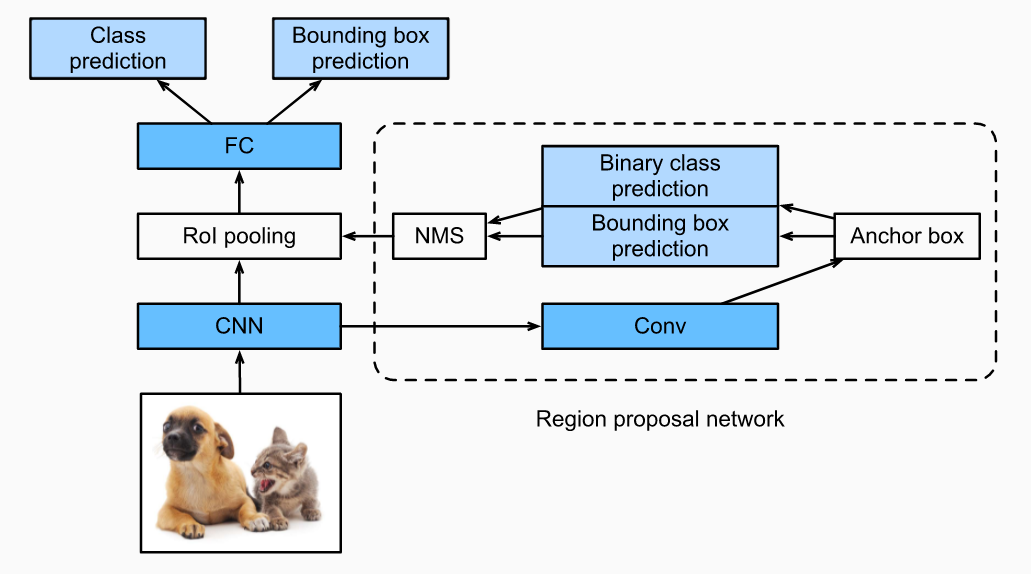

***Single Shot Detection***

*SSD* za *multi-box* predviđanja je jedan od najbržih načina da se postigne izračunavanje zadataka detekcije objekata u realnom vremenu. Dok metodologije *Faster R-CNN* mogu postići visoku tačnost predviđanja, ukupan proces je prilično dugotrajan i zahteva da se zadatak u realnom vremenu izvodi brzinom od oko 7 frejmova u sekundi, što je daleko od poželjnog.

*SSD* rešava ovaj problem poboljšanjem frejmova u sekundi na skoro pet puta više od Faster R-CNN modela. On uklanja korišćenje mreže predloga regiona i umesto toga koristi funkcije višestrukih razmera i podrazumevane okvire.

Iako značajno poboljšava performanse, pati od smanjenja rezolucije slika na niži kvalitet. Zbog ovoga, nećemo koristiti ovaj model za detekciju broda jer su slike satelitske i već su lošije rezolucije. Takođe nije baš najbolji algoritam za detektovanje malih objekata na slikama, a brodovi na satelitskim slikama mogu biti prilično mali.

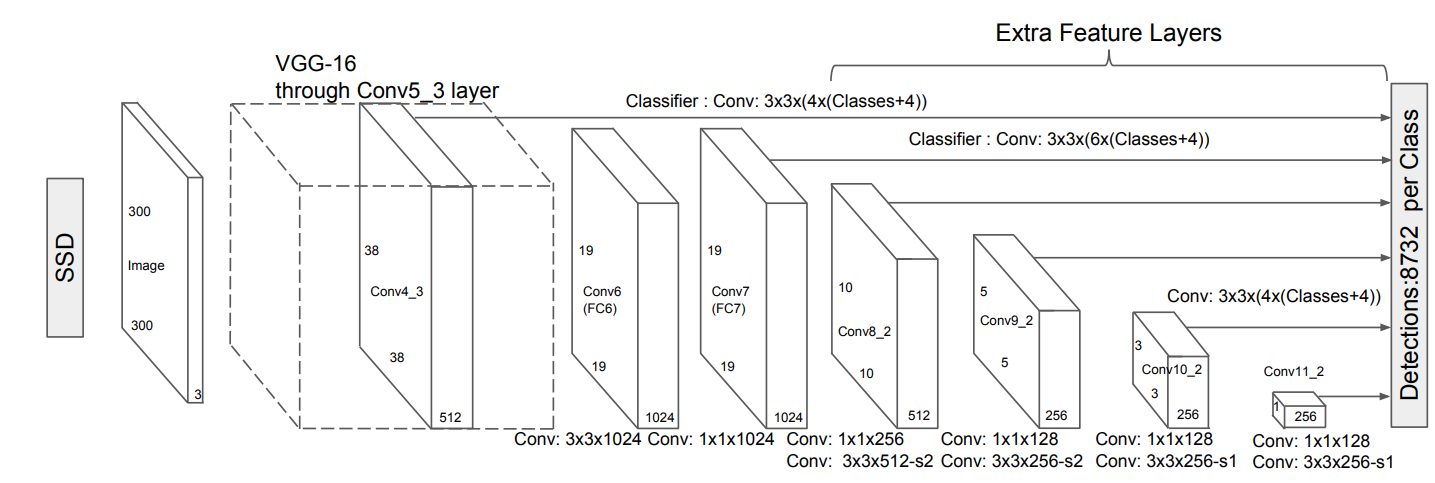

***You Only Look Once***

*Yolo* arhitektura koristi tri primarne terminologije da bi postigla svoj cilj detekcije objekata. Prvi koncept u *Yolo* modelu su rezidualni blokovi. U prvom arhitektonskom dizajnu, koristili su preostale blokove 7×7 za kreiranje mreža na određenoj slici. Svaka od ovih mreža deluje kao centralne tačke i u skladu sa tim se pravi posebno predviđanje za svaku od ovih mreža. U drugoj tehnici, svaka od centralnih tačaka za određeno predviđanje se razmatra za kreiranje graničnih kutija. Dok zadaci klasifikacije dobro funkcionišu za svaku mrežu, složenije je odvojiti granične okvire za svako od predviđanja koja su napravljena. Treća i poslednja tehnika je upotreba preseka unije (*IOU*) za izračunavanje najboljih graničnih okvira za određeni zadatak detekcije objekata. Pored velike brzine računanja, *Yolo* algoritam takođe uspeva da obezbedi opštu visoku tačnost uz smanjenje pozadinskih grešaka koje se vide u drugim metodama.

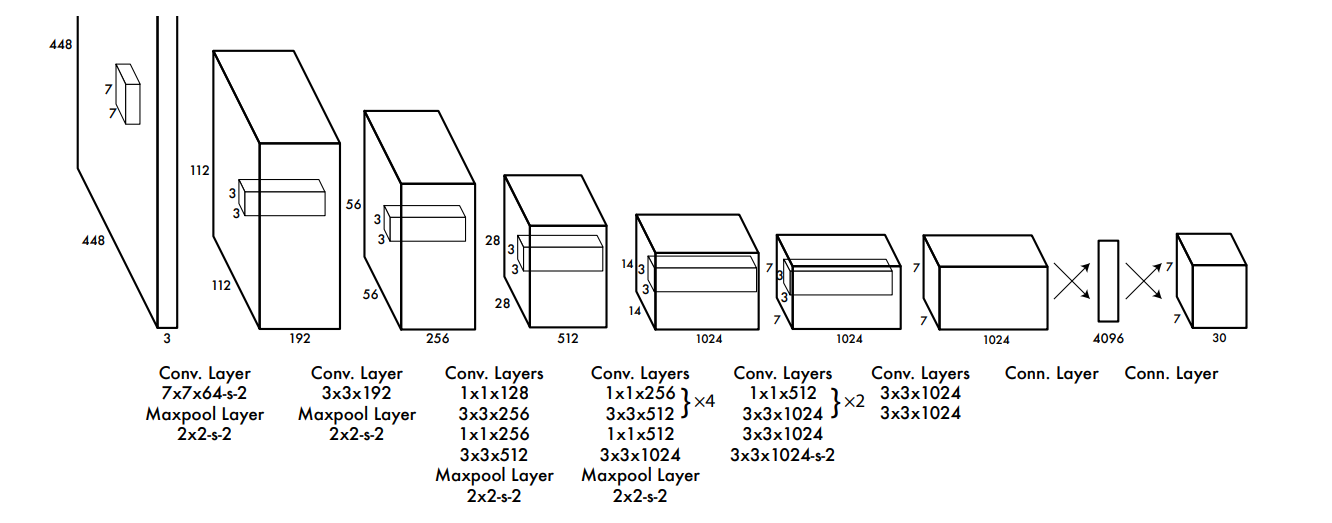

***RetinaNet***

Algoritam koji je zadržao istu brzinu kao i *SSD* i *YOLO*, takođe je u stanju da se takmiči sa porodicom *R-CNN* u pogledu tačnosti. Zbog ovih razloga, *RetinaNet* model nalazi veliku upotrebu u otkrivanju objekata putem satelitskih snimaka i iz tog razloga će biti prikazana njegova implementacija za gore opisani problem detekcije broda.

*RetinaNet* arhitektura je izgrađena na takav način da su prethodna izdanja *SSD*-a donekle izbalansirana kako bi se proizveli efektivniji i efikasniji rezultati. U ovoj arhitekturi modela, gubitak unakrsne entropije u prethodnim modelima je zamenjen fokalnim gubitkom. Fokalni gubitak rešava probleme neravnoteže klase koji postoje u arhitekturama kao što su *YOLO* i *SSD*.

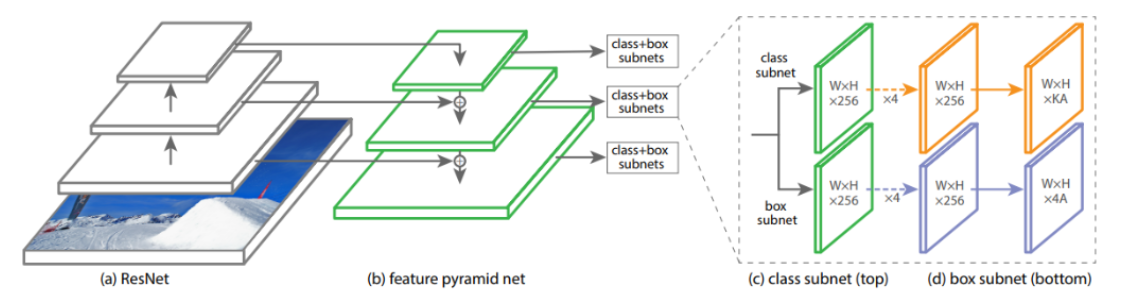

**Literatura**

1. https://neptune.ai/blog/object-detection-algorithms-and-libraries
2. https://imageai.readthedocs.io/en/latest/detection/
3. https://viso.ai/deep-learning/object-detection/#:~:text=on%20Viso%20Suite-,Most%20Popular%20Object%20Detection%20Algorithms,the%20single%2Dshot%20detector%20family.

# Implementacija YOLO i RetinaNet uz pomoć ImageAI biblioteke

ImageAI je biblioteka koja pruža veoma moćne, ali jednostavne klase za korišćenje i funkcije za obavljanje detekcije i ekstrakcije objekata slike. Pošto se bavimo problemom detekcije objekata (broda), biće iskorištena u tu svrhu.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import label
from imageio import imread

import os
import time
import sys


In [4]:
TRAINING_VALIDATION_RATIO = 0.2
WORKING_DIR = '/content/drive/MyDrive/DetekcijaBroda'
INPUT_DIR = '/content/drive/MyDrive/DetekcijaBroda'
OUTPUT_DIR = '/content/drive/MyDrive/DetekcijaBroda'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
TRAIN_DATA_PATH = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH = os.path.join(INPUT_DIR, 'test_v2')
SAMPLE_SUBMISSION_PATH = os.path.join(INPUT_DIR, 'sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'train_ship_segmentations_v2.csv')
MASK_RCNN_PATH = os.path.join(WORKING_DIR, 'Mask_RCNN-master')
COCO_WEIGHTS_PATH = os.path.join(WORKING_DIR, "mask_rcnn_coco.h5")
SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)
test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

In [8]:
masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


<ipython-input-10-51dad2cdca69>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_0 = imread(os.path.join(path, image_id))


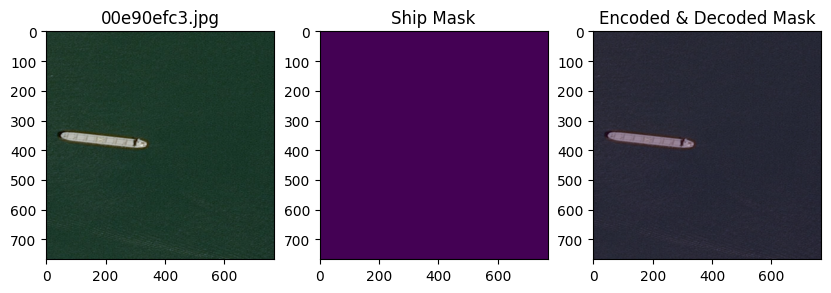

00e90efc3.jpg  Check Decoding->Encoding RLE_0: 0 -> RLE_1: 0


In [10]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):

    pixels = img.T.flatten()

    pixels = np.concatenate([[0], pixels, [0]])

    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=SHAPE):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):

    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

shows_decode_encode('00e90efc3.jpg')


unique_img_ids groupby took: 8.622607707977295


,ImageId,ships,RleMaskList
82661,6dbd3e6db.jpg,1,[393576 3 394344 7 395112 11 395879 14 396647 ...
186197,f79af5246.jpg,2,[416237 1 417003 4 417769 6 418535 9 419301 11...
107517,8ef278f20.jpg,1,[612 30 1379 33 2146 35 2913 37 3681 38 4448 4...


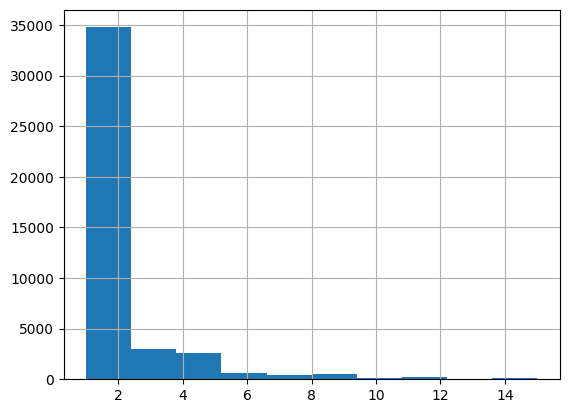

In [11]:
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


<Axes: >

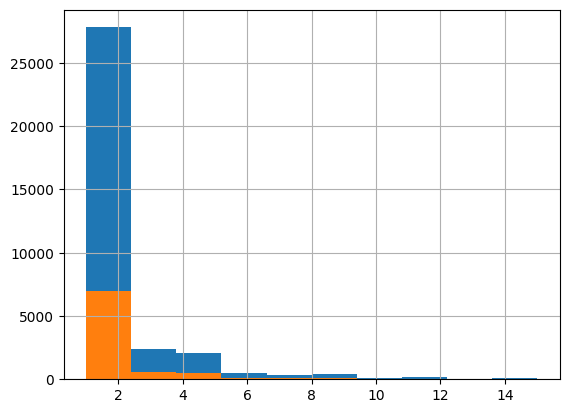

In [12]:
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids,
                 test_size = TRAINING_VALIDATION_RATIO,
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()

In [ ]:
sys.path.append(MASK_RCNN_PATH)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
class DetekcijaBrodaDataset(utils.Dataset):
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height

        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()

    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
class DetekcijaBrodaGPUConfig(Config):
    NAME = 'ASDC_GPU'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05

config = DetekcijaBrodaGPUConfig()
config.display()

In [ ]:
start_time = time.time()
dataset_train = DetekcijaBrodaDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()
dataset_val = DetekcijaBrodaDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

In [ ]:
start_time = time.time()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=WORKING_DIR)

import errno
try:
    weights_path = model.find_last()
    load_weights = True
except FileNotFoundError:
    load_weights = True
    weights_path = COCO_WEIGHTS_PATH
    utils.download_trained_weights(weights_path)

if load_weights:
    print("Loading weights: ", weights_path)
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))


In [ ]:
start_time = time.time()
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE * 1.5,
            epochs=5,
            layers='all')
end_time = time.time() - start_time
print("Train model: {}".format(end_time))

In [ ]:
class InferenceConfig(DetekcijaBrodaGPUConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
infer_model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=WORKING_DIR)

model_path = infer_model.find_last()

print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)

image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

results = infer_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'])

image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
inference_start = time.time()
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = infer_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'])

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))